# Code Demonstration

## Installing required Packages

In [ ]:
# ============================================================
# 0. Install required packages (run once per Colab runtime)
# ============================================================

!pip install elephant neo quantities


## Importing or Loading Libraries

In [ ]:
# ============================================================
# 1. Imports
# ============================================================

import h5py
import numpy as np
import matplotlib.pyplot as plt

import quantities as pq
from neo.core import SpikeTrain

# Elephant modules
from elephant.spike_train_dissimilarity import (
    victor_purpura_distance,
    van_rossum_distance
)
from elephant.spike_train_synchrony import spike_contrast


## Loading the Data

In [ ]:
# ============================================================
# 2. Load HDF5 spike data (same as before)
# ============================================================

file_path = '/scan_data_spike_only.raw.h5'

with h5py.File(file_path, 'r') as f:
    print("Top-level keys:")
    for key in f.keys():
        print("  -", key)

    group_path = 'data_store/data0000'
    if group_path in f:
        group = f[group_path]

        print(f"\nKeys in '{group_path}':")
        for key in group.keys():
            print("  -", key)

        print("\nAttributes in the group:")
        for attr in group.attrs:
            print(f"  - {attr}: {group.attrs[attr]}")

        start_time_raw = float(group['start_time'][()])
        stop_time_raw  = float(group['stop_time'][()])
        print(f"\nRecording range (raw): {start_time_raw:.2f} to {stop_time_raw:.2f}")

        spikes_data = group['spikes'][:]
        print(f"\nSpikes dataset type: {type(spikes_data)}")
        print(f"Spikes dtype: {spikes_data.dtype}")
        print(f"Spikes shape: {spikes_data.shape}")
        print("First 5 entries of spikes data:")
        print(spikes_data[:5])
    else:
        raise ValueError(f"'{group_path}' not found in the file.")


Top-level keys:
  - bits
  - data_store
  - hdf_version
  - mxw_version
  - notes
  - recordings
  - version
  - wellplate
  - wells

Keys in 'data_store/data0000':
  - groups
  - recording_id
  - settings
  - spikes
  - start_time
  - stop_time
  - well_id

Attributes in the group:

Recording range (raw): 1568861340592.00 to 1568861400654.00

Spikes dataset type: <class 'numpy.ndarray'>
Spikes dtype: [('frameno', '<i8'), ('channel', '<i4'), ('amplitude', '<f4')]
Spikes shape: (6150,)
First 5 entries of spikes data:
[(2717644, 734, -4.040781 ) (2718118,  21, -5.357979 )
 (2718162, 594, -4.68218  ) (2718333, 774, -3.6885495)
 (2718387, 127, -4.829276 )]


/tmp/ipython-input-3839853570.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_time_raw = float(group['start_time'][()])
/tmp/ipython-input-3839853570.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stop_time_raw  = float(group['stop_time'][()])


## Preparing the SpikeTrain for ELephant

In [ ]:
# ============================================================
# 3. Convert HDF5 spikes to Neo SpikeTrain list for Elephant
#    (replacing PySpike.SpikeTrain)
# ============================================================

# We assume 'spikes_data' is available from the previous cell.
# It has fields: frameno (i8), channel (i4), amplitude (f4).
# We'll normalize frameno -> seconds (like you did before).

# --- Extract neuron IDs and times ---
if 'channel' in spikes_data.dtype.names and 'frameno' in spikes_data.dtype.names:
    neuron_ids = np.unique(spikes_data['channel'])

    raw_times = spikes_data['frameno'].astype(np.float64)

    # Same normalization idea as before
    time_unit = 1e6  # example scaling, adjust to your real sampling if needed
    normalized_times = (raw_times - raw_times.min()) / time_unit
    t_stop = normalized_times.max()

    spike_trains_neo = []
    for neuron_id in neuron_ids:
        mask = spikes_data['channel'] == neuron_id
        spike_times = np.sort(normalized_times[mask])  # in seconds (float)

        if spike_times.size == 0:
            continue

        st = SpikeTrain(
            spike_times * pq.s,
            t_start=0.0 * pq.s,
            t_stop=t_stop * pq.s
        )
        spike_trains_neo.append(st)

    print(f"Total neurons with spike data: {len(spike_trains_neo)}")
else:
    raise ValueError("Required fields 'channel' and 'frameno' not found in spikes dataset.")


Total neurons with spike data: 543


## Raster Plot

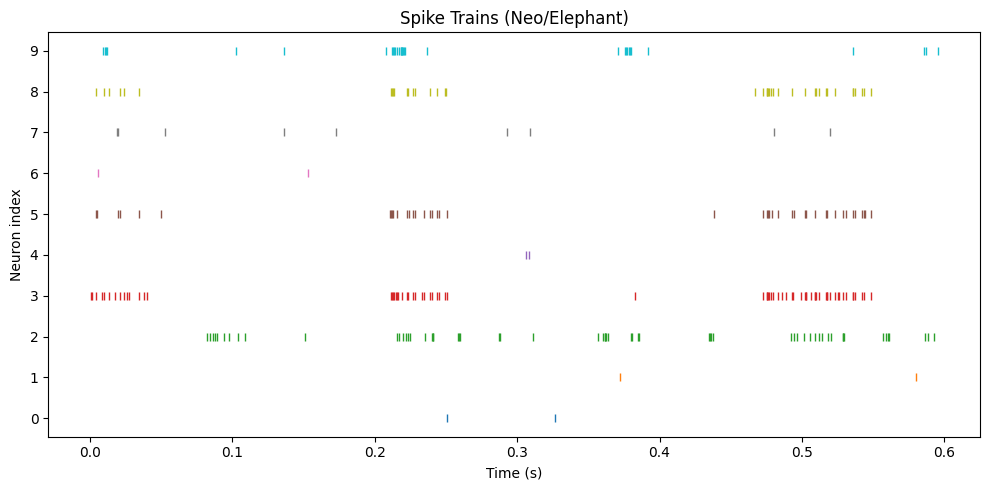

In [ ]:
# ============================================================
# 4. Raster plot of a subset of spike trains (Elephant/Neo)
# ============================================================

def plot_spike_trains_raster(spike_trains, neuron_labels=None):
    plt.figure(figsize=(10, 5))
    for idx, st in enumerate(spike_trains):
        # st is a neo.SpikeTrain; get plain numpy times with .magnitude
        spikes = st.magnitude  # in seconds
        y = np.full_like(spikes, idx, dtype=float)
        plt.plot(spikes, y, '|', markersize=6)
    plt.xlabel("Time (s)")
    plt.ylabel("Neuron index")
    plt.title("Spike Trains (Neo/Elephant)")
    plt.yticks(
        range(len(spike_trains)),
        neuron_labels if neuron_labels is not None else range(len(spike_trains))
    )
    plt.tight_layout()
    plt.show()

subset = spike_trains_neo[:10]
plot_spike_trains_raster(subset)


## Pairwise Distance

In [ ]:
# ============================================================
# 5. Pairwise distances for two neurons using Elephant
#    (analogous to ISI / SPIKE metrics)
# ============================================================

i, j = 0, 1  # pick neuron indices
st1 = subset[i]
st2 = subset[j]

# Elephant expects a list of SpikeTrain objects.
pair_list = [st1, st2]

# Victor–Purpura distance (time-scale dependent spike dissimilarity)
vp_matrix_pair = victor_purpura_distance(pair_list, cost_factor=1.0 / pq.s)
vp_distance = vp_matrix_pair[0, 1]

# van Rossum distance (another time-scale dependent metric)
vr_matrix_pair = van_rossum_distance(pair_list, time_constant=10.0 * pq.ms)
vr_distance = vr_matrix_pair[0, 1]

# Spike-contrast synchrony (time-scale independent synchrony measure)
sync_val, sync_trace = spike_contrast(pair_list, return_trace=True)

print(f"Neuron {i} vs {j}")
print(f"Victor–Purpura distance: {vp_distance:.6f}")
print(f"van Rossum distance   : {vr_distance:.6f}")
print(f"Spike-contrast synchrony: {sync_val:.6f}")


Neuron 0 vs 1
Victor–Purpura distance: 0.374543
van Rossum distance   : 1.994948
Spike-contrast synchrony: 0.546875


## Spike-contrast Trace

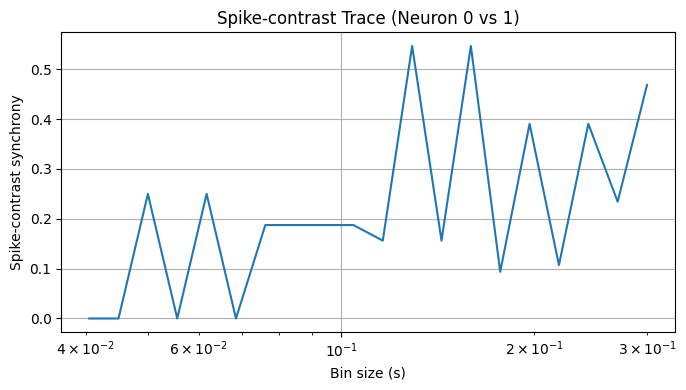

In [ ]:
# ============================================================
# 6. Plot Spike-contrast trace (Elephant analog of a "profile")
# ============================================================

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# sync_trace.bin_size is an array of bin sizes (same length as synchrony, contrast, etc.)
ax.plot(sync_trace.bin_size, sync_trace.synchrony)
ax.set_xscale('log')
ax.set_xlabel("Bin size (s)")
ax.set_ylabel("Spike-contrast synchrony")
ax.set_title(f"Spike-contrast Trace (Neuron {i} vs {j})")
ax.grid(True)

plt.tight_layout()
plt.show()


## Interval-Based Bar Plot

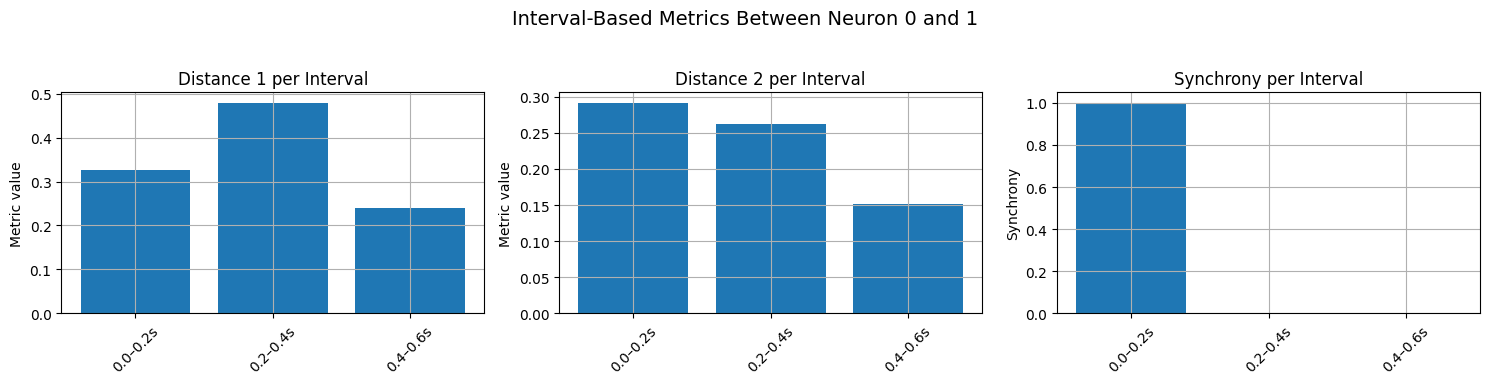

In [ ]:
# ============================================================
# 7. Interval-Based Bar Plot (this part is independent of PySpike)
#    You can keep your original manually computed averages.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# Example numbers from your previous analysis
interval_labels = ["0.0–0.2s", "0.2–0.4s", "0.4–0.6s"]
isi_avg   = [0.32607638, 0.47878589, 0.23880548]   # e.g. from van Rossum / ISI-like
spike_avg = [0.29154369, 0.26237403, 0.15210814]   # e.g. from Victor–Purpura
sync_avg  = [1.0, 0.0, 0.0]                        # example synchrony per interval

x = np.arange(len(interval_labels))

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

ax[0].bar(x, isi_avg)
ax[0].set_title("Distance 1 per Interval")
ax[0].set_xticks(x)
ax[0].set_xticklabels(interval_labels, rotation=45)
ax[0].set_ylabel("Metric value")
ax[0].grid(True)

ax[1].bar(x, spike_avg)
ax[1].set_title("Distance 2 per Interval")
ax[1].set_xticks(x)
ax[1].set_xticklabels(interval_labels, rotation=45)
ax[1].set_ylabel("Metric value")
ax[1].grid(True)

ax[2].bar(x, sync_avg)
ax[2].set_title("Synchrony per Interval")
ax[2].set_xticks(x)
ax[2].set_xticklabels(interval_labels, rotation=45)
ax[2].set_ylabel("Synchrony")
ax[2].grid(True)

fig.suptitle("Interval-Based Metrics Between Neuron 0 and 1", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Full Distance Matrices

In [ ]:
# ============================================================
# 8. Full distance matrices for a subset using Elephant
#    (replacing PySpike's isi_distance_matrix, spike_distance_matrix, etc.)
# ============================================================

subset = spike_trains_neo[:10]

# Victor–Purpura distance matrix
vp_matrix = victor_purpura_distance(subset, cost_factor=1.0 / pq.s)

# van Rossum distance matrix
vr_matrix = van_rossum_distance(subset, time_constant=10.0 * pq.ms)

# Spike-contrast "synchrony matrix" (pairwise) – we build this manually
n = len(subset)
sync_matrix = np.zeros((n, n))

for a in range(n):
    for b in range(n):
        if a == b:
            sync_matrix[a, b] = 1.0
        elif b < a:
            # symmetry
            sync_matrix[a, b] = sync_matrix[b, a]
        else:
            sync_val_ab = spike_contrast([subset[a], subset[b]])
            sync_matrix[a, b] = sync_val_ab

print("Victor–Purpura distance matrix:\n", vp_matrix)
print("van Rossum distance matrix:\n", vr_matrix)
print("Spike-contrast synchrony matrix:\n", sync_matrix)


Victor–Purpura distance matrix:
 [[ 0.        0.374543 58.02378  69.056442  0.073319 42.080994  0.41849
   7.059588 39.077657 31.05821 ]
 [ 0.374543  0.       58.014325 69.042098  0.337206 42.097732  0.793033
   7.123138 39.126191 31.007195]
 [58.02378  58.014325  0.       13.380773 58.020216 16.963154 58.078829
  51.229456 19.965619 27.746438]
 [69.056442 69.042098 13.380773  0.       69.114303 27.065295 69.059349
  62.232316 30.019832 39.04961 ]
 [ 0.073319  0.337206 58.020216 69.114303  0.       42.118331  0.455827
   7.013731 39.114994 31.131529]
 [42.080994 42.097732 16.963154 27.065295 42.118331  0.       42.058007
  35.226716  3.161815 12.232389]
 [ 0.41849   0.793033 58.078829 69.059349  0.455827 42.058007  0.
   7.030141 39.059349 31.020605]
 [ 7.059588  7.123138 51.229456 62.232316  7.013731 35.226716  7.030141
   0.       32.244017 24.31548 ]
 [39.077657 39.126191 19.965619 30.019832 39.114994  3.161815 39.059349
  32.244017  0.       10.045951]
 [31.05821  31.007195 27.7464

## Heatmaps|

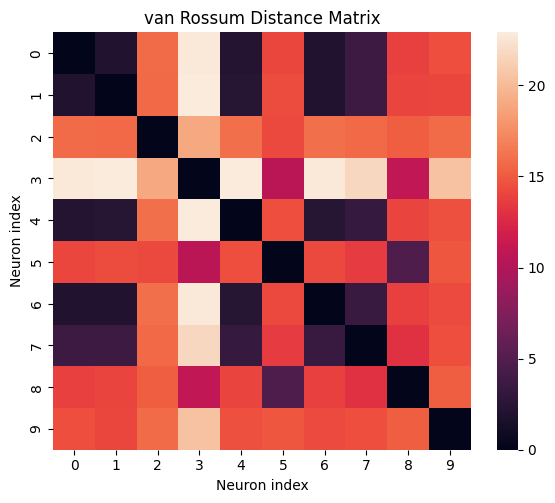

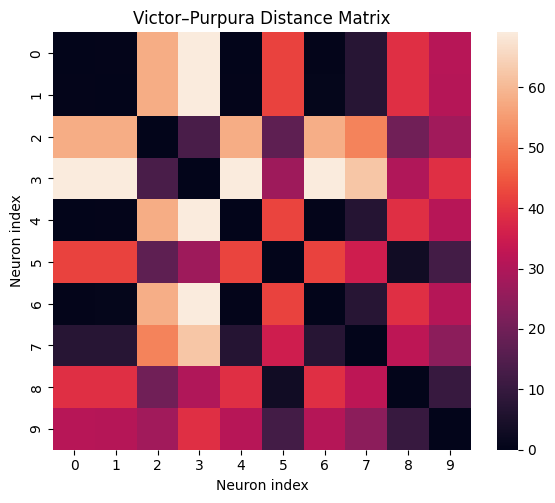

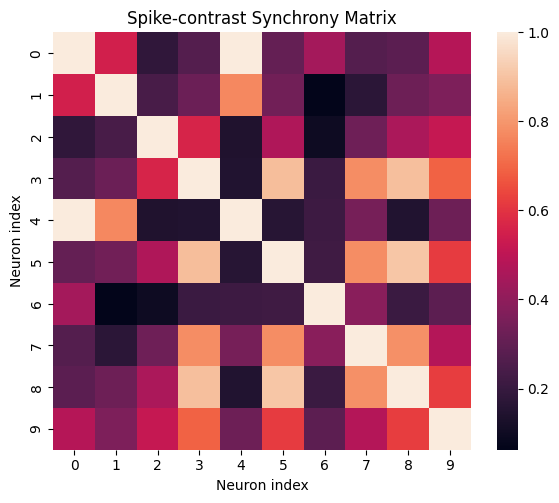

In [ ]:
# ============================================================
# 9. Heatmaps: Distance & Synchrony matrices (Elephant)
# ============================================================

import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(vr_matrix, annot=False, square=True)
plt.title("van Rossum Distance Matrix")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.tight_layout()

plt.figure(figsize=(6, 5))
sns.heatmap(vp_matrix, annot=False, square=True)
plt.title("Victor–Purpura Distance Matrix")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.tight_layout()

plt.figure(figsize=(6, 5))
sns.heatmap(sync_matrix, annot=False, square=True)
plt.title("Spike-contrast Synchrony Matrix")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.tight_layout()

plt.show()


## Comparison for two selected neurons (e.g., 8 vs 3)


Neuron 8 vs 3
Victor–Purpura distance: 30.0198
van Rossum distance   : 10.8497
Spike-contrast synchrony: 0.8929


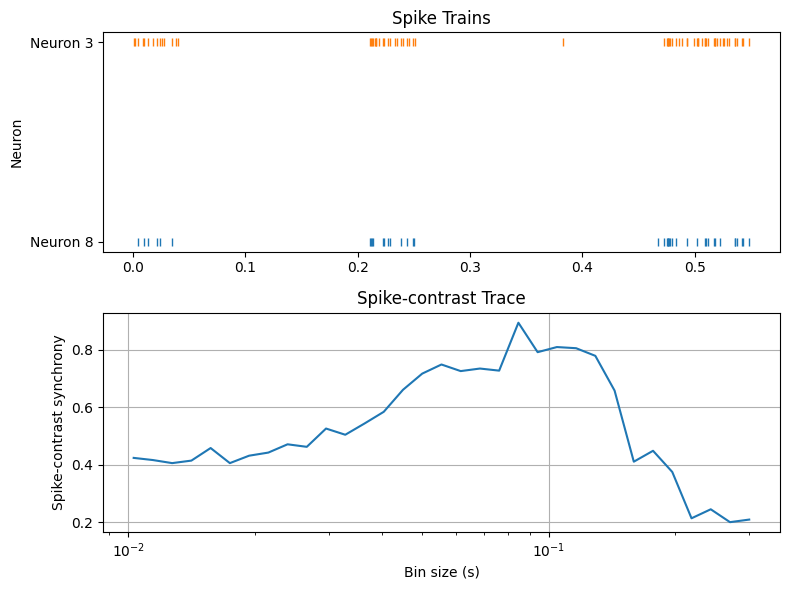

In [ ]:
# ============================================================
# 10. Detailed comparison for two selected neurons (e.g., 8 vs 3)
# ============================================================

i, j = 8, 3  # neuron indices inside 'subset'
st_i = subset[i]
st_j = subset[j]

pair_list_ij = [st_i, st_j]

vp_ij  = victor_purpura_distance(pair_list_ij, cost_factor=1.0 / pq.s)[0, 1]
vr_ij  = van_rossum_distance(pair_list_ij, time_constant=10.0 * pq.ms)[0, 1]
sync_ij, trace_ij = spike_contrast(pair_list_ij, return_trace=True)

print(f"\nNeuron {i} vs {j}")
print(f"Victor–Purpura distance: {vp_ij:.4f}")
print(f"van Rossum distance   : {vr_ij:.4f}")
print(f"Spike-contrast synchrony: {sync_ij:.4f}")

# Plot raster + spike-contrast trace
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

# Raster for the two neurons
for idx, st in enumerate(pair_list_ij):
    spikes = st.magnitude
    y = np.full_like(spikes, idx, dtype=float)
    axs[0].plot(spikes, y, '|')
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels([f"Neuron {i}", f"Neuron {j}"])
axs[0].set_ylabel("Neuron")
axs[0].set_title("Spike Trains")

# Spike-contrast trace
axs[1].plot(trace_ij.bin_size, trace_ij.synchrony)
axs[1].set_xscale('log')
axs[1].set_xlabel("Bin size (s)")
axs[1].set_ylabel("Spike-contrast synchrony")
axs[1].set_title("Spike-contrast Trace")
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Merging two neurons

Merged SpikeTrain (Neuron 3 + 8):
[4.74000e-04 1.66900e-03 4.23600e-03 4.23600e-03 8.68600e-03 1.00080e-02
 1.00090e-02 1.36420e-02 1.36420e-02 1.75810e-02 2.10990e-02 2.10990e-02
 2.42770e-02 2.42780e-02 2.57460e-02 2.74760e-02 3.46100e-02 3.46100e-02
 3.80420e-02 4.02250e-02 2.11221e-01 2.11221e-01 2.12035e-01 2.12036e-01
 2.12927e-01 2.12927e-01 2.13870e-01 2.13870e-01 2.15142e-01 2.15786e-01
 2.16277e-01 2.18847e-01 2.22456e-01 2.22456e-01 2.23686e-01 2.23687e-01
 2.26812e-01 2.26812e-01 2.28321e-01 2.28322e-01 2.33454e-01 2.34875e-01
 2.38808e-01 2.38808e-01 2.39928e-01 2.43914e-01 2.43914e-01 2.45373e-01
 2.49406e-01 2.49406e-01 2.50181e-01 2.50872e-01 3.82814e-01 4.66907e-01
 4.72944e-01 4.72945e-01 4.75432e-01 4.75433e-01 4.75786e-01 4.75786e-01
 4.76123e-01 4.76124e-01 4.77185e-01 4.77185e-01 4.78175e-01 4.78177e-01
 4.79642e-01 4.79643e-01 4.83067e-01 4.83067e-01 4.86043e-01 4.88836e-01
 4.92725e-01 4.92725e-01 4.93450e-01 4.99403e-01 5.02118e-01 5.02118e-01
 5.02658e-01 5.03

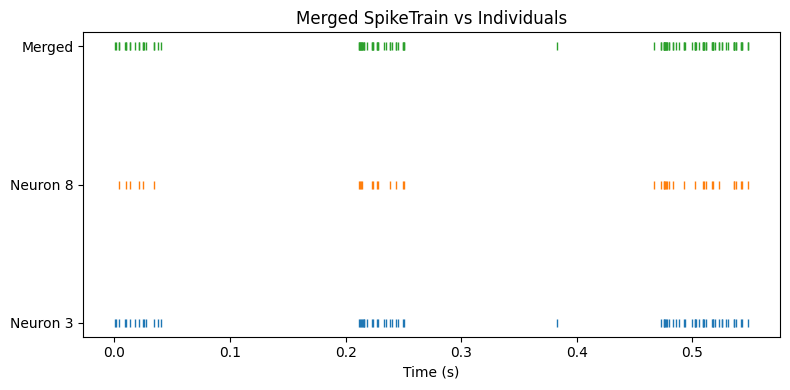

In [ ]:
# ============================================================
# 11. Merging two neurons' SpikeTrains (Elephant/Neo equivalent)
#    Replacing pyspike.merge_spike_trains
# ============================================================

neuron_a = 3
neuron_b = 8

st_a = subset[neuron_a]
st_b = subset[neuron_b]

# Combine and sort times, preserve units
combined_times = np.sort(
    np.concatenate([st_a.magnitude, st_b.magnitude])
) * st_a.units

merged_spiketrain = SpikeTrain(
    combined_times,
    t_start=min(st_a.t_start, st_b.t_start),
    t_stop=max(st_a.t_stop, st_b.t_stop)
)

print(f"Merged SpikeTrain (Neuron {neuron_a} + {neuron_b}):")
print(merged_spiketrain)

# Optional: plot merged vs individual
plt.figure(figsize=(8, 4))
for idx, st in enumerate([st_a, st_b, merged_spiketrain]):
    spikes = st.magnitude
    y = np.full_like(spikes, idx, dtype=float)
    plt.plot(spikes, y, '|', markersize=6)
plt.yticks([0, 1, 2], [f"Neuron {neuron_a}", f"Neuron {neuron_b}", "Merged"])
plt.xlabel("Time (s)")
plt.title("Merged SpikeTrain vs Individuals")
plt.tight_layout()
plt.show()
